# The dataset WFM mask

In [1]:
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

datafile_path = "../assets/aux.fits"

In [2]:
mask_list, header = fits.getdata(datafile_path, ext=2, header=True)
header, mask_list

(XTENSION= 'BINTABLE'           / binary table extension                         
 BITPIX  =                    8 / array data type                                
 NAXIS   =                    2 / number of array dimensions                     
 NAXIS1  =                   12 / length of dimension 1                          
 NAXIS2  =               676000 / length of dimension 2                          
 PCOUNT  =                    0 / number of group parameters                     
 GCOUNT  =                    1 / number of groups                               
 TFIELDS =                    3 / number of table fields                         
 TTYPE1  = 'X       '                                                            
 TFORM1  = 'E       '                                                            
 TUNIT1  = 'mm      '                                                            
 TTYPE2  = 'Y       '                                                            
 TFORM2  = 'E   

In [3]:
def l2m(ml):
    return binned_statistic_2d(
        ml["X"], ml["Y"], ml["VAL"], 
        statistic="max", 
        bins=[
            np.arange(-130, 130.1, 0.25), 
            np.arange(-130, 130.1, 0.4),
        ])[0].T

### Mask array

In [4]:
mask = l2m(mask_list)

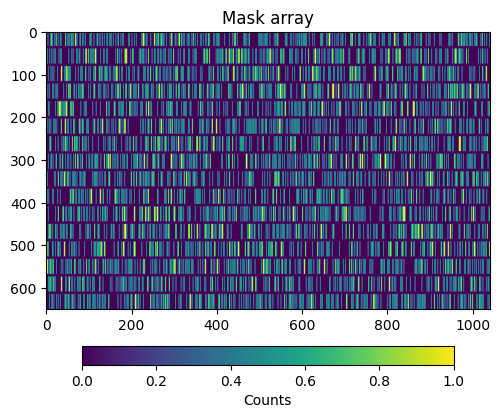

In [5]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(mask)
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad = 0.1, shrink=.75)
ax.set_title("Mask array")
plt.show()

### Reconstruction matrix

In [6]:
rec_list, header = fits.getdata(datafile_path, ext=3, header=True)
reconstruction = l2m(rec_list)

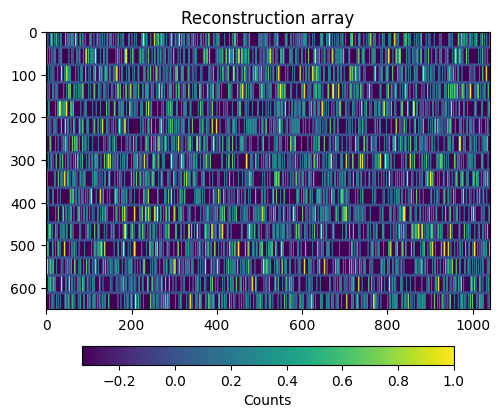

In [7]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(reconstruction)
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad = 0.1, shrink=.75)
ax.set_title("Reconstruction array")
plt.show()

### Bulk array

In [8]:
bulk_list, header = fits.getdata(datafile_path, ext=4, header=True)
bulk = l2m(bulk_list)

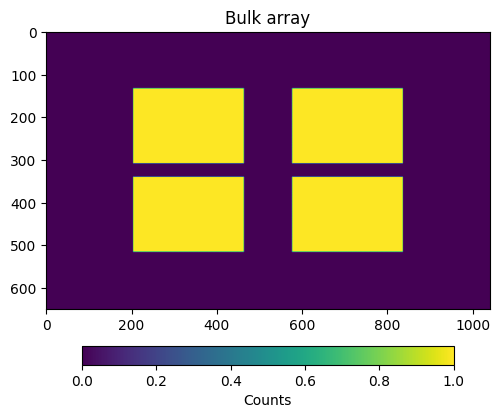

In [9]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(bulk)
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad=0.1, shrink=.75)
ax.set_title("Bulk array")
plt.show()

# Single, non-poissonian source with no background

In [10]:
from pathlib import Path
from scipy.signal import correlate
import numpy.typing as npt

class WFM:
    def __init__(self, filepath: Path):
        self.filepath = filepath
        self.mask = l2m(fits.getdata(datafile_path, ext=2))
        self.decoder = l2m(fits.getdata(datafile_path, ext=3))
        self.bulk = l2m(fits.getdata(datafile_path, ext=4))
        self.shape = self.mask.shape
        self.open_fraction = np.sum(self.mask) / np.prod(self.shape)
        self._norm = 1 / np.sum(self.mask)

    def encode(self, sky: npt.NDArray) -> npt.NDArray:
        detector = correlate(self.mask, sky, mode="same") * self._norm
        return detector * self.bulk
    
    def decode(self, detector: npt.NDArray, balanced: bool | npt.NDArray = False) -> npt.NDArray:
        cc = correlate(self.decoder, detector, mode="full")
        if balanced is False:
            return cc
        return cc - correlate(self.decoder, self.bulk, mode="full") * np.sum(detector) / np.sum(bulk)

    def psf(self) -> npt.NDArray:
        return correlate(self.mask, self.decoder, mode="same")
    
    def get_sky_canvas(self) -> npt.NDArray:
        n, m = self.shape
        return np.zeros((2 * n, 2 * m))

In [11]:
wfm = WFM(datafile_path)

In [12]:
sky = wfm.get_sky_canvas()
for source in [(*mask.shape, 1000)]:
    x, y, counts = source
    sky[x, y] = counts

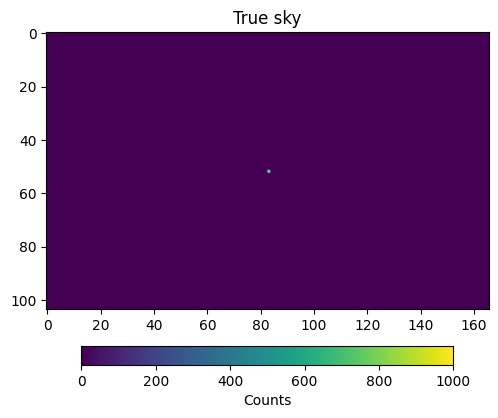

In [13]:
zoom = tuple(map(lambda x: slice(x // 2 - x // 25,  x // 2 + x // 25), sky.shape))

fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(sky[*zoom])
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad=0.1, shrink=.75)
ax.set_title("True sky")
plt.show()

In [14]:
detector = wfm.encode(sky)

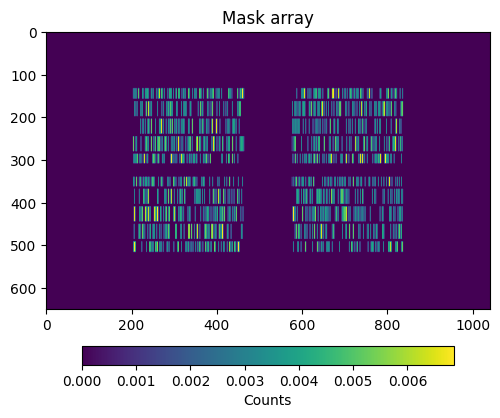

In [15]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad = 0.1, shrink=.75)
ax.set_title("Mask array")
plt.show()

Let's look at the reconstruted sky, we zoom in otherwise we can't see anything.

In [16]:
reconstructed = wfm.decode(detector, balanced=False)
balanced = wfm.decode(detector, balanced=True)

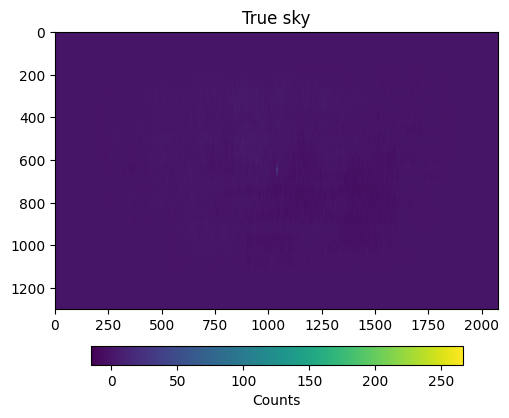

In [17]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(reconstructed)
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad=0.1, shrink=.75)
ax.set_title("True sky")
plt.show()

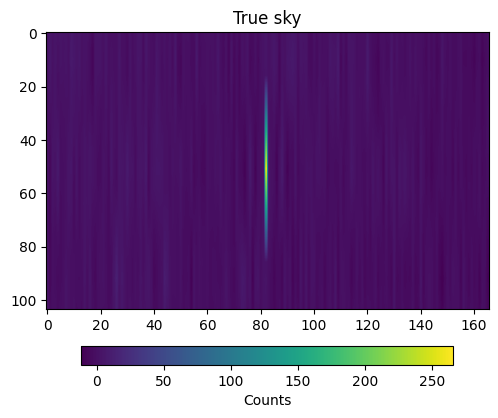

In [18]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(reconstructed[*zoom])
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad=0.1, shrink=.75)
ax.set_title("True sky")
plt.show()

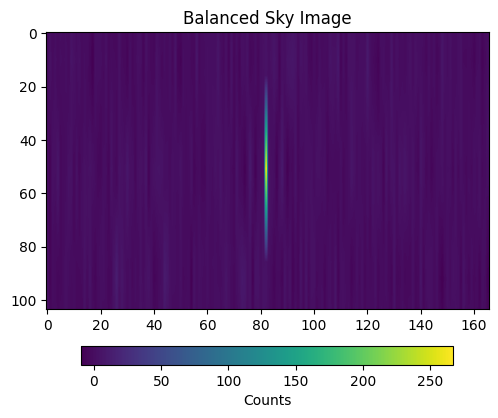

In [19]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(balanced[*zoom])
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad=0.1, shrink=.75)
ax.set_title("Balanced Sky Image")
plt.show()

# A basic simulation

In [51]:
def simulate(fsources, b, mask, dsources = None):
    sky = mask.get_sky_canvas()
    n, m = sky.shape
    if dsources is None:
        dsources = np.dstack(
            [
                np.random.randint(n, size=len(fsources)),
                np.random.randint(m, size=len(fsources)),
            ]
        )[0]
        
    detector = np.zeros(mask.shape)
    transmitted = []
    for dsource, fsource in zip(dsources, fsources):
        _sky = mask.get_sky_canvas()
        _sky[*dsource] = fsource
        shadowed =np.isclose(mask.encode(_sky), np.zeros(mask.shape))
        counts = np.random.poisson(fsource / np.prod(mask.shape), size=mask.shape)
        counts[shadowed] = 0
        
        transmitted.append(np.sum(counts).item())
        detector += counts
        sky += _sky
    detector += np.random.poisson(b * mask.open_fraction, size=mask.mask.shape)
    sky += np.ones((n,m)) * b
    return detector, sky, {"source_directions": dsources, "source_transmitted": transmitted}

In [52]:
detector, sky, infos = simulate([100000, 50000], .05, wfm)
detector *= wfm.bulk
print(infos)

{'source_directions': array([[ 398, 1105],
       [ 301, 1474]]), 'source_transmitted': [3913, 812]}


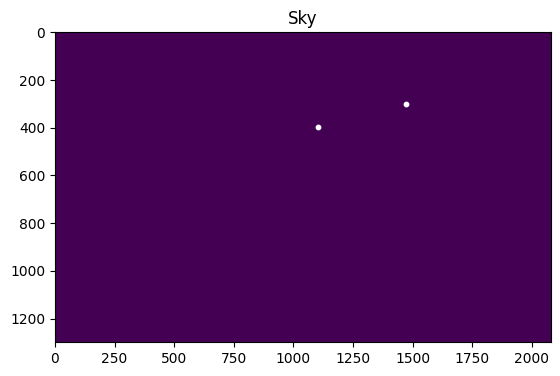

In [53]:
fig, ax = plt.subplots(1, 1)
c0 = ax.imshow(sky)
xs, ys = infos["source_directions"].T
plt.scatter(ys, xs, s=10, c="white")
ax.set_title("Sky")
plt.show()

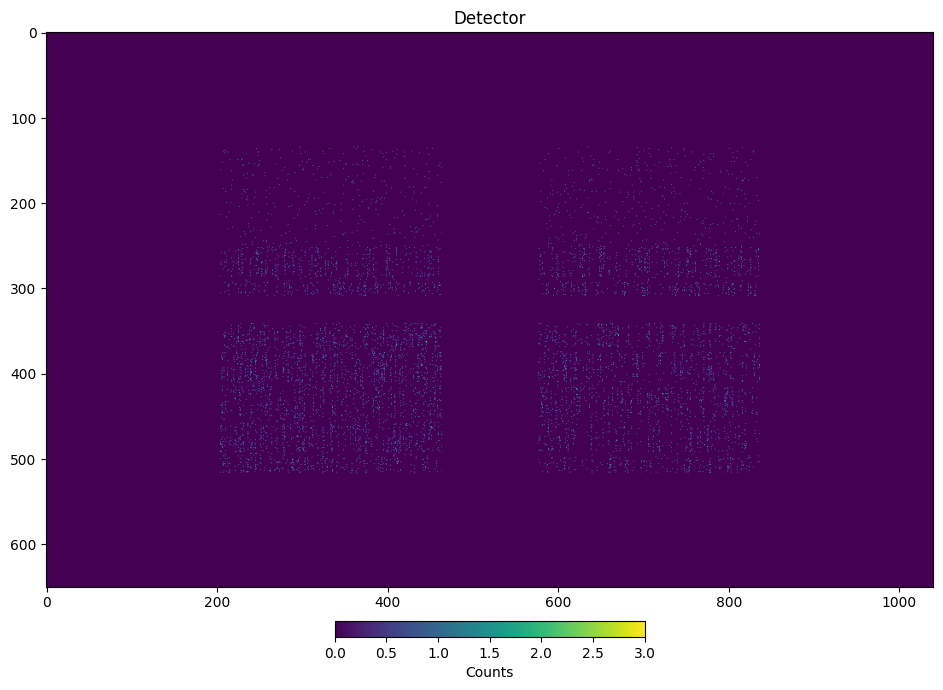

In [54]:
fig, ax = plt.subplots(1, 1,  figsize=(16,9))
c0 = ax.imshow(detector)
fig.colorbar(c0, ax=ax, label="Counts", location="bottom", pad=0.05, shrink=.25)
ax.set_title("Detector")
plt.show()

In [55]:
reconstructed = wfm.decode(detector, balanced=False)
balanced = wfm.decode(detector, balanced=True)

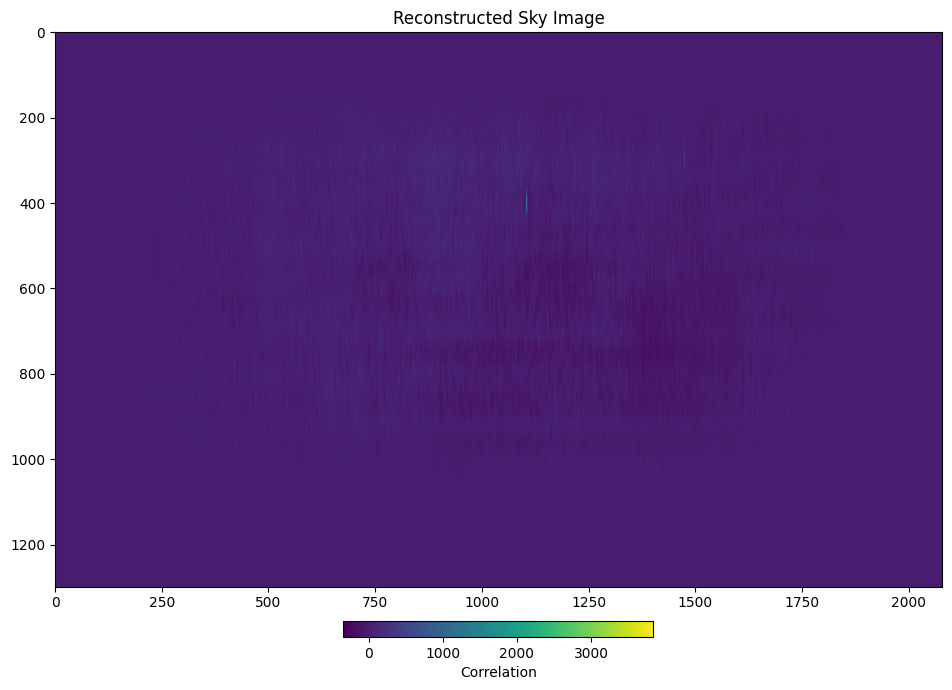

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
c0 = ax.imshow(reconstructed)
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", pad=0.05, shrink=.25)
ax.set_title("Reconstructed Sky Image")
plt.show()

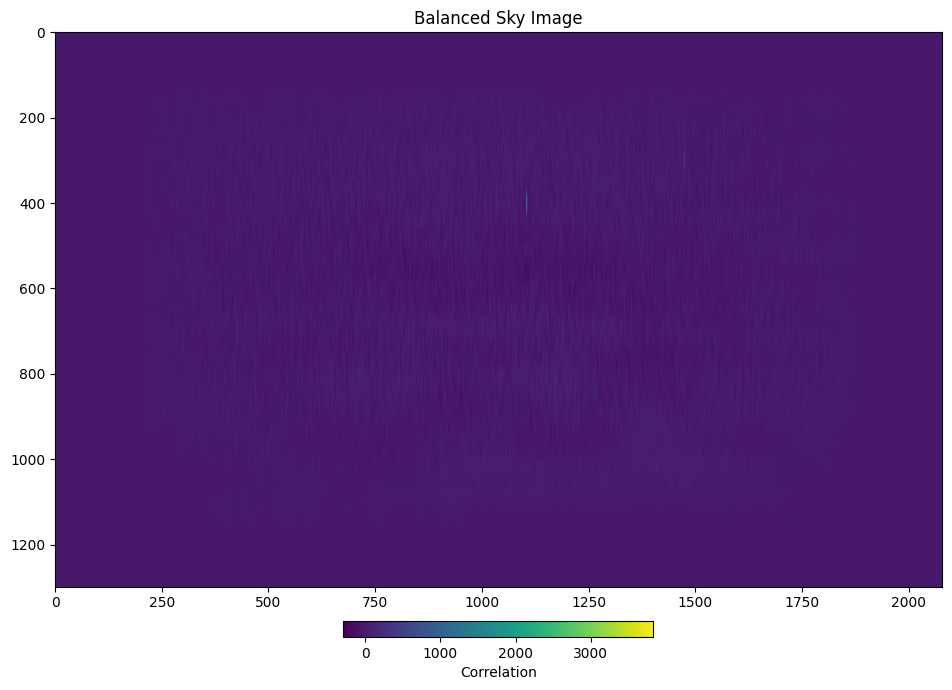

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(16,9))
c0 = ax.imshow(balanced)
fig.colorbar(c0, ax=ax, label="Correlation", location="bottom", pad=0.05, shrink=.25)
ax.set_title("Balanced Sky Image")
plt.show()

In [58]:
xs, ys = zip(*infos["source_directions"])

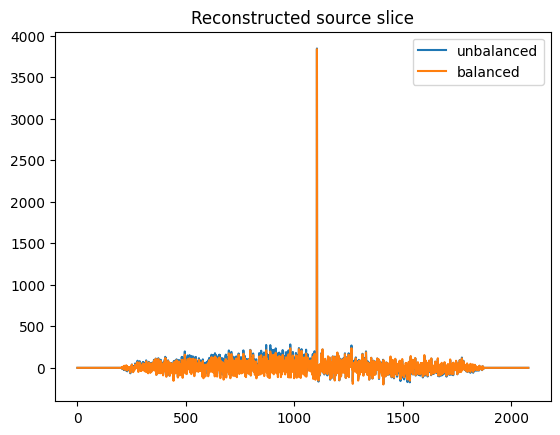

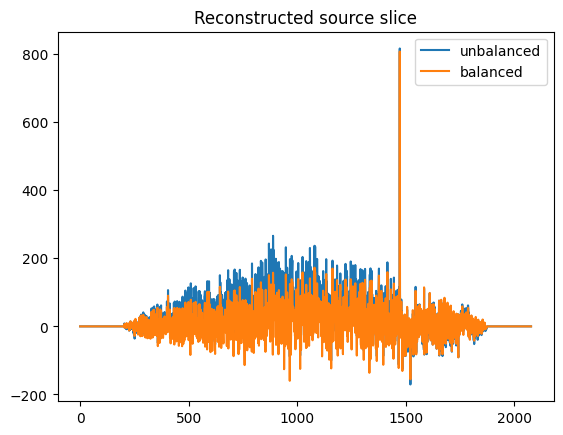

In [59]:
for x in xs:
    plt.show()
    plt.plot(reconstructed[x - 1], label="unbalanced")
    plt.plot(balanced[x - 1], label="balanced")
    plt.title("Reconstructed source slice")
    plt.legend()
    plt.show()

We can see that the slice peaks match the number of source photons transmitted to the detector.

In [63]:
infos["source_transmitted"]

[3913, 812]